In [1]:
import os
import numpy as np
import cv2 # Using OpenCV for image loading and resizing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob # To easily find potato folders



In [2]:

# --- Configuration ---
DATA_DIR = './PlantVillage/PlantVillage'
POTATO_FOLDER_PREFIX = 'Potato___'
IMG_SIZE = 64  # Resize images to 64x64 (smaller for faster processing)
N_HIDDEN_UNITS_ELM = 1000 # Number of hidden neurons in ELM (Hyperparameter)
RANDOM_STATE = 42 # For reproducibility

# --- 1. Load Potato Image Data ---
print(f"Loading potato images from: {DATA_DIR}")
image_paths = []
labels = []

# Find all potato subdirectories
potato_dirs = glob.glob(os.path.join(DATA_DIR, f'{POTATO_FOLDER_PREFIX}*'))
if not potato_dirs:
    print(f"Error: No directories starting with '{POTATO_FOLDER_PREFIX}' found in '{DATA_DIR}'")
    exit()

print(f"Found potato directories: {[os.path.basename(d) for d in potato_dirs]}")

for class_dir in potato_dirs:
    class_name = os.path.basename(class_dir)
    image_files = glob.glob(os.path.join(class_dir, '*.JPG')) # Assuming JPG extension
    if not image_files:
         image_files = glob.glob(os.path.join(class_dir, '*.jpg')) # Try lowercase
    print(f"  Loading {len(image_files)} images from {class_name}...")
    for img_path in image_files:
        try:
            # Read image using OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Load as grayscale
            if img is None:
                print(f"    Warning: Could not read image {img_path}. Skipping.")
                continue
            # Resize image
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            # Flatten image into a 1D vector
            img_vector = img_resized.flatten()
            image_paths.append(img_vector)
            labels.append(class_name)
        except Exception as e:
            print(f"    Error processing image {img_path}: {e}")

if not image_paths:
    print("Error: No potato images were loaded successfully.")
    exit()

print(f"\nLoaded {len(image_paths)} total potato images.")


Loading potato images from: ./PlantVillage/PlantVillage
Found potato directories: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
  Loading 1000 images from Potato___Early_blight...
  Loading 1000 images from Potato___Late_blight...
  Loading 152 images from Potato___healthy...

Loaded 2152 total potato images.


In [3]:

# --- 2. Prepare Data ---
X = np.array(image_paths)
y_str = np.array(labels)

# Normalize pixel values (0-255 -> 0-1)
X = X / 255.0

# Encode string labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_str)
class_names = label_encoder.classes_
print(f"\nClasses found: {class_names}")
print(f"Data shape (X): {X.shape}") # (num_images, img_size*img_size)
print(f"Labels shape (y): {y.shape}")

# Split data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y # Stratify helps maintain class balance
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Classes found: ['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']
Data shape (X): (2152, 4096)
Labels shape (y): (2152,)

Training set size: 1614
Testing set size: 538


In [4]:

# --- 3. ELM Feature Extraction ---

# ELM core logic: Generate random weights/biases and compute hidden layer output
def elm_hidden_output(X, n_hidden, input_weights=None, biases=None):
    """Calculates the output of the ELM hidden layer."""
    n_input_features = X.shape[1]
    np.random.seed(RANDOM_STATE) # Ensure reproducibility for random weights

    if input_weights is None:
        input_weights = np.random.randn(n_input_features, n_hidden) * 0.1 # Smaller weights often work better
    if biases is None:
        biases = np.random.randn(n_hidden) * 0.1

    # Calculate hidden layer activation (using ReLU activation function)
    H = np.maximum(0, X @ input_weights + biases) # ReLU activation
    # Alternatives: Sigmoid: 1 / (1 + np.exp(-(X @ input_weights + biases)))
    return H, input_weights, biases

print(f"\nExtracting ELM features with {N_HIDDEN_UNITS_ELM} hidden units...")
start_time_elm = time.time()

# Fit ELM on training data (generate weights/biases)
X_train_elm, elm_weights, elm_biases = elm_hidden_output(X_train, N_HIDDEN_UNITS_ELM)

# Transform test data using the *same* weights and biases
X_test_elm, _, _ = elm_hidden_output(X_test, N_HIDDEN_UNITS_ELM, elm_weights, elm_biases)

elm_time = time.time() - start_time_elm
print(f"ELM feature extraction completed in {elm_time:.2f} seconds.")
print(f"Shape of ELM features (Train): {X_train_elm.shape}") # (num_train_images, n_hidden_units)
print(f"Shape of ELM features (Test): {X_test_elm.shape}")   # (num_test_images, n_hidden_units)



Extracting ELM features with 1000 hidden units...
ELM feature extraction completed in 1.62 seconds.
Shape of ELM features (Train): (1614, 1000)
Shape of ELM features (Test): (538, 1000)


In [5]:

# --- 4. Feature Scaling (Important for SVM) ---
print("\nScaling ELM features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_elm)
X_test_scaled = scaler.transform(X_test_elm) # Use the same scaler fitted on training data

# --- 5. SVM Classification ---
print("\nTraining SVM classifier...")
start_time_svm = time.time()

# Initialize SVM Classifier (using Radial Basis Function kernel by default)
# You can experiment with C and gamma parameters, or kernel='linear'
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RANDOM_STATE, probability=True) # probability=True for potential calibration later

# Train the SVM model
svm_classifier.fit(X_train_scaled, y_train)

svm_time = time.time() - start_time_svm
print(f"SVM training completed in {svm_time:.2f} seconds.")



Scaling ELM features...

Training SVM classifier...
SVM training completed in 5.48 seconds.



Evaluating SVM model on the test set...

Accuracy: 0.8346

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.85      0.93      0.89       250
 Potato___Late_blight       0.82      0.87      0.84       250
     Potato___healthy       0.00      0.00      0.00        38

             accuracy                           0.83       538
            macro avg       0.56      0.60      0.58       538
         weighted avg       0.78      0.83      0.80       538


Confusion Matrix:
[[232  18   0]
 [ 33 217   0]
 [  7  31   0]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

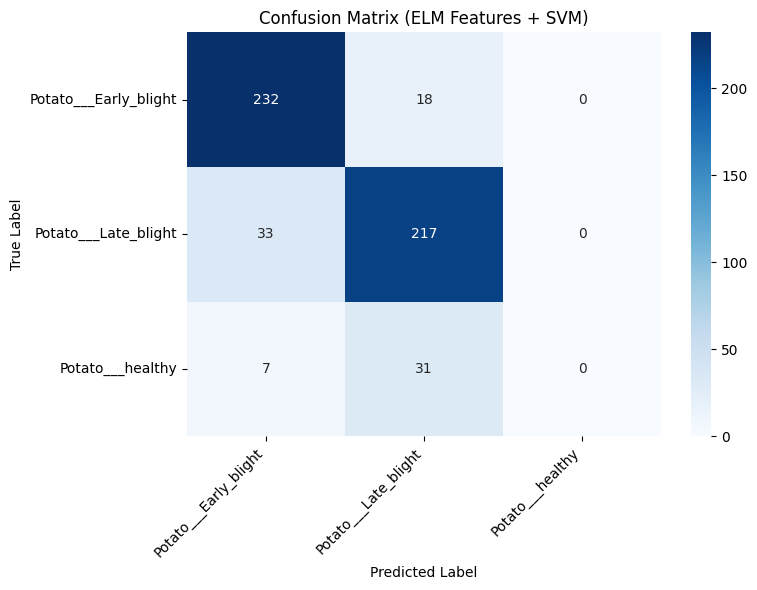


--- Workflow Complete ---


In [6]:

# --- 6. Evaluation ---
print("\nEvaluating SVM model on the test set...")

# Predict on the test data
y_pred = svm_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (ELM Features + SVM)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- Workflow Complete ---")
